In [1]:
import subprocess;
import platform;
import pandas as pd;
import numpy as np;
from shapely.geometry import Point
import geopandas
# matplotlib requires installation of the descartes package to plot the isovist polygons
import matplotlib.pyplot as plt
import os
import math

In [2]:
# this just selects the correct depthmapXcli from the lib folder, depending on the
# depending on the operating system jupyter python is running on (darwin is macOS)

if platform.system() == "Windows":
    depthmapXcli = "./lib/depthmapXcli.exe"
elif platform.system() == "Darwin":
    depthmapXcli = "./lib/depthmapXcli.darwin"
elif platform.system() == "Linux":
    depthmapXcli = "./lib/depthmapXcli.linux"
else:
    raise ValueError('Unknown platform: ' + platform.system())

In [3]:
# Uncomment the next lines and run them to generate a text file with the cli options
# with open("depthmapXcli_commands.txt", "w") as text_file:
#     text_file.write(subprocess.check_output([depthmapXcli, "-h"]).decode("utf-8"))

In [4]:
# Create two isovists in the gallery_connected.graph file and write a new file called
# out.graph which contains the results. The -ii parameter defines the isovists with 4
# numbers: x, y, angle, viewangle. The last two values angle and viewangle define the
# viewing direction and field of view respectively, both in degrees
subprocess.check_output([depthmapXcli,
                         "-f",  "data/gallery_connected.graph",
                         "-o",  "data/out.graph",
                         "-m",  "ISOVIST", 
                         "-ii", "2.75, 6.80, 320, 90", 
                         "-ii", "4.95, 6.55, 150, 90"])

b'Loading graph data/gallery_connected.graph ok\nMaking 2 isovists...  ok\nWriting out result... ok\n'

In [5]:
# Convert the isovists to a convex map (can't export data-maps yet)
subprocess.check_output([depthmapXcli,
                         "-f",   "data/out.graph",
                         "-o",   "data/out.graph",
                         "-m",   "MAPCONVERT",
                         "-co",  "convex",
                         "-con", "tempconvex"]);

In [6]:
# Export the isovists from out.graph into a mif/mid pair called 'out.mif'
# and 'out.mid' and erase the former out.graph file
subprocess.check_output([depthmapXcli,
                         "-f",  "data/out.graph",
                         "-o",  "data/out.mif",
                         "-m",  "EXPORT",
                         "-em", "shapegraph-map-mif"]);
os.remove("data/out.graph")

In [7]:
# read the mif file into a variable
isovists = geopandas.read_file("data/out.mif")
# set the CRS to avoid having geopandas complain
isovists.crs = ''
# delete the mif/mid files
os.remove("data/out.mif")
os.remove("data/out.mid")

In [8]:
# to make visualisation easier load the gallery plan (from a shapefile) for later plotting
galleryPlan = geopandas.read_file("data/gallery-plan.shp")
galleryPlan.crs = ''

<AxesSubplot:>

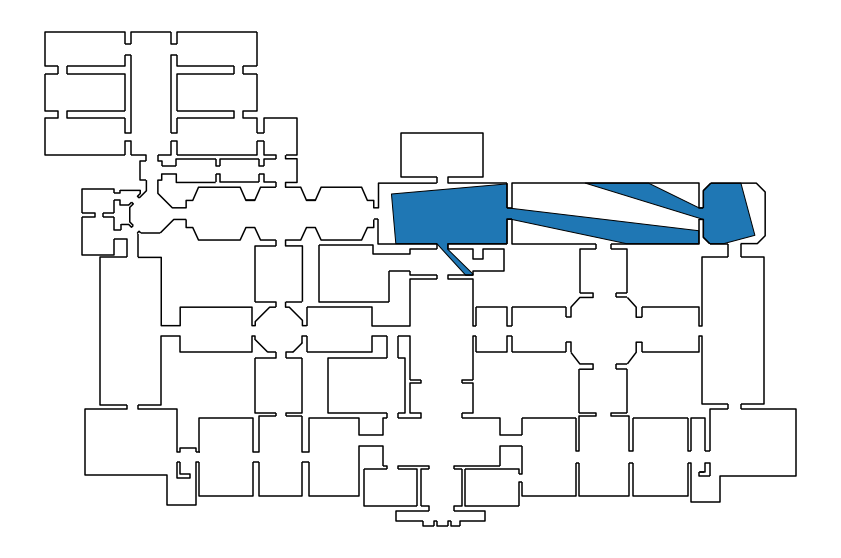

In [9]:
# quick plot to see the outcome of the above (should be two isovists)
fig, ax = plt.subplots(figsize=(20, 10))
ax.axis('off')
ax.set_aspect('equal')
galleryPlan.plot(ax=ax, edgecolor='black')
isovists.plot(ax=ax, edgecolor='black')

In [10]:
# generate a bunch of points to test whether the isovist can "see" them
# i.e. whether they are within the isovist polygon
origin_x = 3.53
origin_y = 6.53
point_dist = 0.05
point_matrix = [[origin_x + x * point_dist, origin_y + y * point_dist] for x in range(22) for y in range(7)]
gallery_points = geopandas.GeoDataFrame(geometry=geopandas.points_from_xy(x=[item[0] for item in point_matrix],
                                          y=[item[1] for item in point_matrix]))
gallery_points.crs = ''

In [11]:
# make a data frame with the same number of columns as isovists and rows as points
# and fill this with True if a point is in an isovist or False if not
point_in_isovist = np.transpose(isovists.apply(lambda row:
                                               gallery_points.intersects(isovists.loc[[row.name]].unary_union),
                                               axis=1))

point_in_isovist.columns = "in_isovist_" + isovists['Depthmap_Ref'].map(str)
# not strictly necessary, but make a single column indicating
# in which isovist the point has been found in
point_in_isovist['which_isovist'] = point_in_isovist.eq(True).dot(point_in_isovist.columns)
gallery_points = gallery_points.join(point_in_isovist)
gallery_points

,geometry,in_isovist_0,in_isovist_1,which_isovist
0,POINT (3.53000 6.53000),False,False,
1,POINT (3.53000 6.58000),False,False,
2,POINT (3.53000 6.63000),False,False,
3,POINT (3.53000 6.68000),True,False,in_isovist_0
4,POINT (3.53000 6.73000),False,False,
...,...,...,...,...
149,POINT (4.58000 6.63000),False,False,
150,POINT (4.58000 6.68000),False,True,in_isovist_1
151,POINT (4.58000 6.73000),False,True,in_isovist_1
152,POINT (4.58000 6.78000),False,False,


<AxesSubplot:>

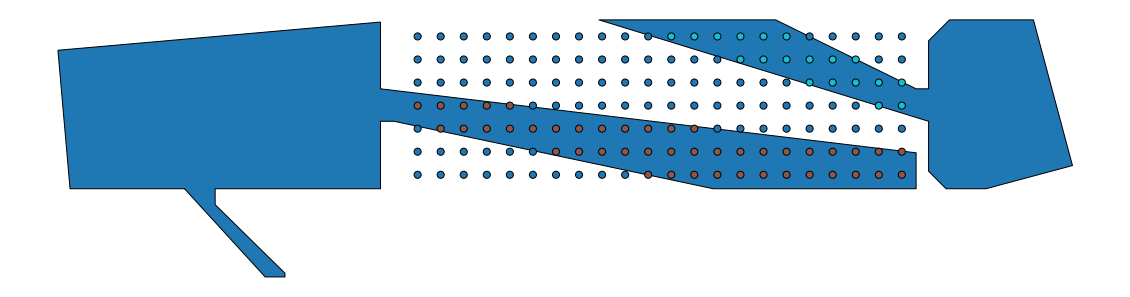

In [12]:
# plot the isovists and the points on top, coloured according to which isovist they are in
fig, ax = plt.subplots(figsize=(20, 10))
ax.axis('off')
ax.set_aspect('equal')
isovists.plot(ax=ax, edgecolor='black')
gallery_points.plot(ax=ax, edgecolor='black', column='which_isovist', markersize = 50)

<AxesSubplot:>

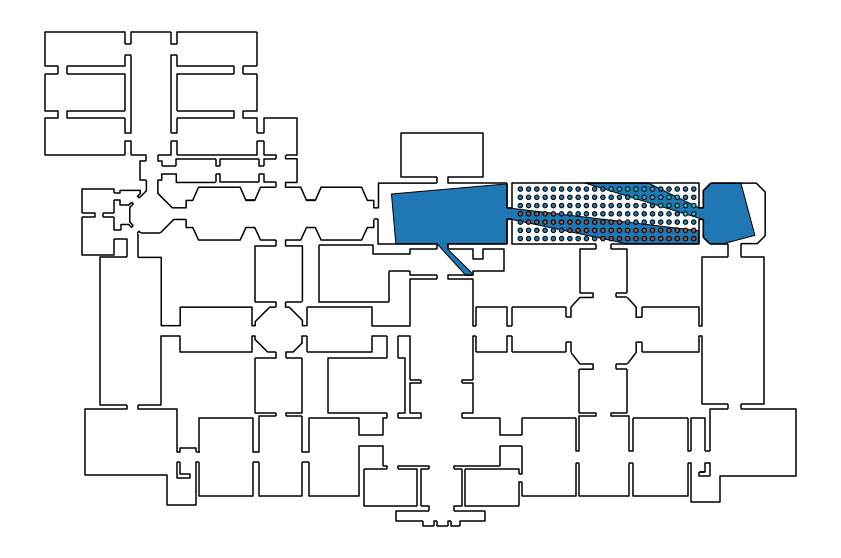

In [13]:
# plot the gallery with the isovists and points on top
fig, ax = plt.subplots(figsize=(20, 10))
ax.axis('off')
ax.set_aspect('equal')
galleryPlan.plot(ax=ax, edgecolor='black')
isovists.plot(ax=ax, edgecolor='black')
gallery_points.plot(ax=ax, edgecolor='black', column='which_isovist', markersize = 20)